# Higher order limb darkening
Here we'll go over how to compute analytic light curves for stars with arbitrary order limb darkening.

Let's begin by importing what we'll need:

In [1]:
import starry
import numpy as np
import matplotlib.pyplot as pl
from scipy.optimize import curve_fit

In [2]:
%matplotlib inline

For completeness, let's begin by defining our polynomial limb darkening model. Recall that for quadratic limb darkening, the specific intensity of the star as a function of $\cos\theta \equiv \mu$ is given by

$\frac{I(\mu)}{I(1)} = 1 - u_1(1-\mu) - u_2(1-\mu)^2$

We can generalize this to arbitrary order by writing

$\frac{I(\mu)}{I(1)} = 1 - u_1(1-\mu) - u_2(1-\mu)^2 - u_3(1-\mu)^3 - \, ... - \, u_{l_\mathrm{max}}(1-\mu)^{l_\mathrm{max}}$

or, in more compact form,

$\frac{I(\mu)}{I(1)} = 1 - \sum_{l=1}^{l_\mathrm{max}}u_l(1-\mu)^l$

In [3]:
def IofMu(mu, *u):
    """Return the specific intensity as a function of `mu`."""
    return (1 - np.sum([u[l] * (1 - mu) ** l for l in range(1, len(u))], axis=0))

Now say that we have the values of $I(\mu)$ at specific values of $\mu$ from an actual stellar model for a given type of star. Say we have ten measurements, equally spaced from $\mu=1$ (the center of the disk) to $\mu=0$ (the limb):

In [4]:
mu = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.0]
I = [1.0, 0.95904139, 0.91381385, 0.86332286, 0.80617997, 0.74036269,
     0.66275783, 0.56820172, 0.44715803, 0.2787536,  0.0]

## Obtaining a limb darkening model

Our task is to fit our model to these values and determine the coefficients $u_l$ so we can compute transit light curves. One of the most common parametrizations in the literature is the quadratic limb darkening model, which is a function of only two coefficients: $u_1$ and $u_2$. Let's use the `curve_fit` function from `scipy` to get the best-fitting quadratic model to our data:

In [5]:
guess = [1, 0, 0]
u, _ = curve_fit(IofMu, mu, I, guess)
print(u)

[1.         0.08425405 0.84010058]


/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Like any seasoned Python user, let's ignore that warning and see how our model looks:

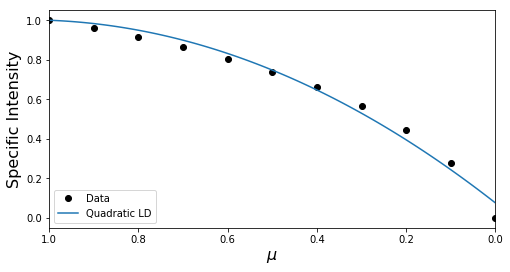

In [6]:
fig, ax = pl.subplots(1, figsize=(8, 4))
ax.plot(mu, I, 'ko', label='Data')
mu_hires = np.linspace(0, 1, 100)
ax.plot(mu_hires, IofMu(mu_hires, *u), label='Quadratic LD')
ax.set_xlim(1, 0)
ax.set_xlabel(r'$\mu$', fontsize=16)
ax.set_ylabel('Specific Intensity', fontsize=16)
ax.legend(loc='lower left')
pl.show()

Not *terrible*, but there's some discrepancy, especially near the limb. But since the transit model for this type of limb darkening is analytic (Mandel & Agol 2002), this model is still widely used.

Fortunately, with **starry**, we can do a lot better. Note that we have 11 data points, so if we fit a **10th order limb darkening model**, we can have it thread through every single data point exactly.* 

**Having a model that fits your data exactly is usually not a good thing in astronomy, but since our "data" are actually a model output with no error bars,
and since they're evenly sampled, you'll see that a polynomial fit is actually a fine way to interpolate between the points.*

In [7]:
guess = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
u10, _ = curve_fit(IofMu, mu, I, guess)
print(u10)

[   1.            0.3808126     0.46161071   -3.17984934   20.52042657
  -76.88780388  183.27909456 -278.3376703   261.79360945 -139.06500771
   32.03477734]


/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Again, let's ignore the warning and plot both models to see how we did:

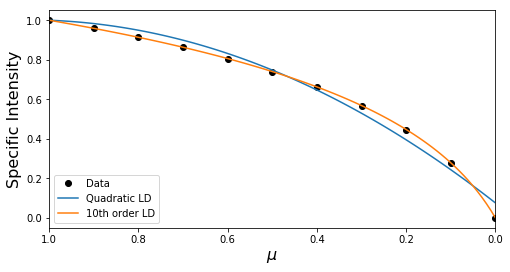

In [8]:
fig, ax = pl.subplots(1, figsize=(8, 4))
ax.plot(mu, I, 'ko', label='Data')
mu_hires = np.linspace(0, 1, 100)
ax.plot(mu_hires, IofMu(mu_hires, *u), label='Quadratic LD')
ax.plot(mu_hires, IofMu(mu_hires, *u10), label='10th order LD')
ax.set_xlim(1, 0)
ax.set_xlabel(r'$\mu$', fontsize=16)
ax.set_ylabel('Specific Intensity', fontsize=16)
ax.legend(loc='lower left')
pl.show()

Sweet -- as expected, the 10th order model fits the data perfectly and the interpolation between points seems reasonable. No onto the magic part: transit light curves!

## Computing transit light curves

Let's compute a simple transit light curve for an edge-on hot Jupiter ($r_o = 0.1$). Let's compute 10,000 points so we can also look at some speed tests:

In [9]:
npts = 10000
r = 0.1
b = np.linspace(-1.5, 1.5, npts)

First, business as usual: instantiate the default `LimbDarkenedMap`, assign the linear and quadratic limb darkening coefficients, and compute the transit flux. Recall that `u[0]` is fixed so we never need to assign it.

In [10]:
map = starry.Map()
map[1] = u[1]
map[2] = u[2]
%time flux = map.flux(xo=b, yo=0, ro=r)

CPU times: user 1.26 ms, sys: 48 µs, total: 1.31 ms
Wall time: 1.32 ms


OK, now let's go bonkers and compute the transit flux for the 10th order limb darkening model.

In [11]:
map10 = starry.Map(10)
map10[:] = u10[1:]
%time flux10 = map10.flux(xo=b, yo=0, ro=r)

CPU times: user 52.7 ms, sys: 286 µs, total: 53 ms
Wall time: 52.9 ms


In [12]:
map10.flux(xo=0.009, yo=0, ro=r)

0.9877984624871035

That took about 30 times longer, but it is still blazing fast. Let's now plot and compare the two transit light curves:

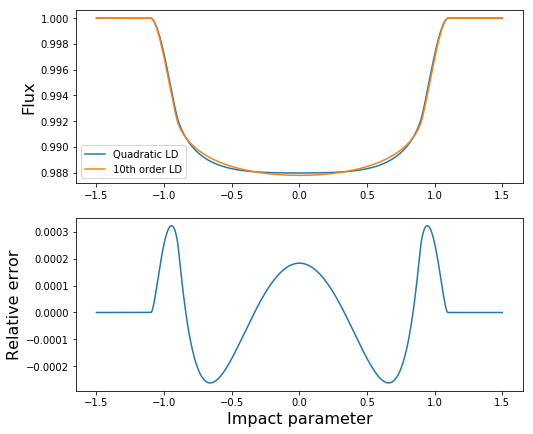

In [13]:
fig, ax = pl.subplots(2, figsize=(8, 7))
ax[0].plot(b, flux, '-', label='Quadratic LD')
ax[0].plot(b, flux10, '-', label='10th order LD')
ax[1].plot(b, flux - flux10, '-')
ax[0].legend(loc='lower left')
ax[0].set_ylabel('Flux', fontsize=16)
ax[1].set_ylabel('Relative error', fontsize=16)
ax[1].set_xlabel('Impact parameter', fontsize=16)
pl.show()

The difference isn't huge in this case: the maximum relative error is about 300 ppm. This doesn't matter for most applications, but it is noticeable by eye. As our instrumentation gets better (I'm thinking JWST!) this could become important.